1. 데이터 준비   
 1.1 csv데이터   


In [1]:
# PATH변경
import pandas as pd
label_df = pd.read_csv('./Dataset/train.csv')
label_df.head()

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


 1.2 이미지 데이터

In [2]:
import os
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    label_df = pd.read_csv('./Dataset/train.csv')
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    #print(glob(os.path.join(data_dir,'*.PNG')))
    # /로 짤린 것 중에서 맨 뒤( *.PNG) + 거기서 '.'으로 나뉘는 파일이름으로 정렬
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(label_df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x : int(x.split('/')[-1].split('.')[0]) )

    return img_path_list


2. 데이터 확인
 2. 1 csv 데이터

In [3]:
print(label_df.head())
label_df.info()


  file_name  label
0   001.PNG      9
1   002.PNG      4
2   003.PNG      1
3   004.PNG      1
4   005.PNG      6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  723 non-null    object
 1   label      723 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


   2.2 이미지 데이터

In [4]:
all_img_path, all_label = get_train_data('./Dataset/train')
#test_img_path = get_test_data('./Dataset/test')
print(all_img_path[:5])
print(all_label[:5])

classes = ('63 Building', 'Namsan Tower', 'Gyeongbokgung Palace', 'Gwangjang Market', 'Hyundai Department Store', 'Ttukseom Hangang Park', 'Lotte World Tower', 'Bongeunsa Temple', 'Bukchon Hanok Village', 'Seoul Forest')

['./Dataset/train/001.PNG', './Dataset/train/002.PNG', './Dataset/train/003.PNG', './Dataset/train/004.PNG', './Dataset/train/005.PNG']
[9, 4, 1, 1, 6]


3. 환경설정   
데이터를 전처리 하기 위한 GPU 환경설정

In [5]:
import torch
import torch.nn as nn
# 병렬화 비활성화
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
# GPU를 정렬 , 0번 부터
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # Arrange GPU devices starting from 0
# 사용하고자 하는 GPU빼고 나머지 제한
#os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Set the GPU 2 to us, multi gpu
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')


cuda:1
torch version : 1.12.1


In [6]:
# GPU 체크 및 할당
if torch.cuda.is_available():
    print('Device :',device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU :', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

Device : cuda:1
There are 2 GPU(s) available.
We will use the GPU : NVIDIA GeForce RTX 3090 Ti


In [7]:
import numpy as np
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(41)

데이터 전처리   
CustomDataset

In [8]:
import torchvision.datasets as datasets # 데이터셋 
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self,index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

    

In [9]:
# import matplotlib.font_manager as fm

# font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')

# font_list[:]

CustomDataset으로 만든 Data확인

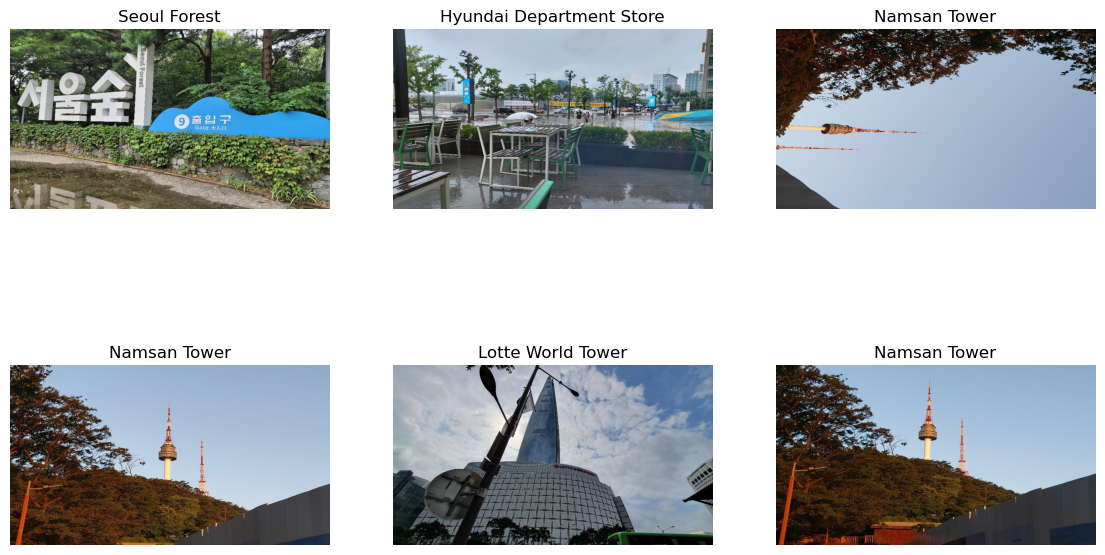

In [39]:
temp_dataset = CustomDataset(all_img_path,all_label, train_mode=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(temp_dataset.__getitem__(i)[0][...,::-1])
    plt.title(classes[temp_dataset.__getitem__(i)[1]])
    plt.axis('off')

전체 이미지 mean과 std 구하기

In [11]:
# 모든 이미지의 사이즈 확인
# mean과 std 구하기
import numpy as np
temp_transform = transforms.Compose([
    transforms.ToTensor(), # tensor로 변경
])
temp_dataset = CustomDataset(
    all_img_path,all_label, train_mode=False, transforms=temp_transform)

def find_info(dataset):
    img_size = []
    img_mean = np.empty((0,3))
    img_std = np.empty((0,3))
    #print(len(dataset)) -> 723개
    for i in range(len(dataset)):
        img = dataset.__getitem__(i)
        m = np.mean(np.array(img),axis=(1,2))
        s = np.std(np.array(img),axis=(1,2))
        img_mean = np.append(img_mean,[m],axis=0)
        img_std = np.append(img_std,[s],axis=0)
        #print(np.array(img).shape) # 3,540,960
        #print(img_mean.shape)      # (3,)
        #print(img_std.shape)       # (3,)

        if img.shape not in img_size:
            img_size.append(img.shape)
    #print(img_mean.shape)
    mean_r = round(np.mean(img_mean[:,0]),3)
    mean_g = round(np.mean(img_mean[:,1]),3)
    mean_b = round(np.mean(img_mean[:,2]),3)
    mean = (mean_r, mean_g, mean_b)
    
    std_r = round(np.mean(img_std[:,0]),3)
    std_g = round(np.mean(img_std[:,1]),3)
    std_b = round(np.mean(img_std[:,2]),3)
    std = (std_r,std_g,std_b)

    return img_size, mean, std

#img_size, img_mean, img_std = find_info(temp_dataset)
img_size = [[3,540,960]]
img_mean = (0.475, 0.470, 0.458)
img_std = (0.295, 0.264, 0.254)
print(f'img_size = {img_size}')
print(f'img mean = {img_mean}')
print(f'img std = {img_std}')


img_size = [[3, 540, 960]]
img mean = (0.475, 0.47, 0.458)
img std = (0.295, 0.264, 0.254)


Train / Validation split   
전체 데이터에서 분리

In [12]:
train_len = int(len(all_img_path)*0.7)
val_len = int(len(all_img_path)*0.3)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

val_img_path = all_img_path[train_len:]
val_label = all_label[train_len:]

In [13]:
print(f'train set 크기 : {len(train_img_path)}')
print(f'val set 크기 : {len(val_img_path)}')

train set 크기 : 506
val set 크기 : 217


하이퍼 파라미터 값 설정

In [14]:
CFG = {
    'IMG_SIZE':256,
    'CROP_SIZE':224,
    'EPOCHS':200,
    'BATCH_SIZE':16,
}

Transform

In [15]:
import torchvision.transforms.functional as TF
from typing import Sequence

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)


train_transform = transforms.Compose([
    transforms.ToPILImage(), # numpy --> PIL로 변경
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]), #128 * 128이미지로 사이즈변경
    transforms.RandomAffine(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.CenterCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(), # tensor로 변경
    transforms.Normalize(mean=img_mean, std=img_std), # 이미지 정규화 
    #MyRotateTransform([-90,0,90]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['IMG_SIZE'],CFG['IMG_SIZE']]),
    transforms.CenterCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

DataLoader

In [16]:
train_dataset = CustomDataset(
    train_img_path, 
    train_label,
    train_mode=True,
    transforms=train_transform
    )
train_loader = DataLoader(
    train_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=True
)

val_dataset = CustomDataset(
    val_img_path,
    val_label,
    train_mode=True,
    transforms=test_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=False
)

In [17]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print(f'total train imgs : {train_len} / total train batches :{train_batches}')
print(f'total val imgs : {val_len} / total val batches :{val_batches}')

total train imgs : 506 / total train batches :32
total val imgs : 216 / total val batches :14


torch.Size([16, 3, 224, 224])


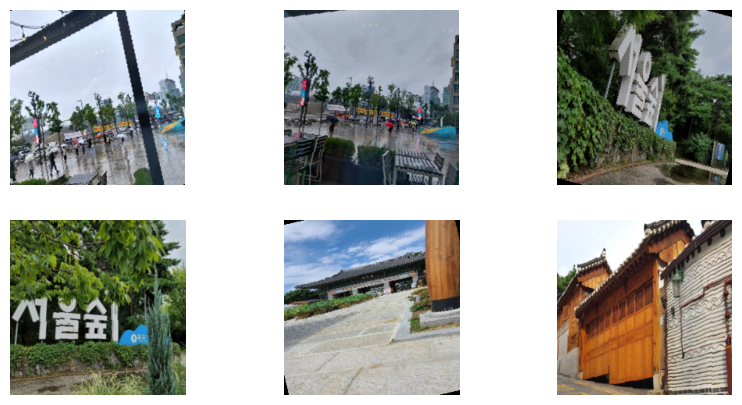

In [18]:
img, _ = next(iter(train_loader))
print(img.shape)
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    k = img[i] * torch.tensor(img_std).view(3, 1, 1) + torch.tensor(img_mean).view(3, 1, 1)
    plt.imshow(k.detach().cpu().numpy().transpose(1,2,0)[...,::-1])
    plt.axis('off')

Model 학습

In [19]:
from tqdm import tqdm

def train(model,optimizer,criterion, train_loader, scheduler,device,name):
    model.to(device)
    n = len(train_loader)
    best_acc = 0
    count = 1
    best_loss = 100
    # train시 저장할 것들
    history = {}
    history['train_loss'] =[]
    history['train_acc'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    history['class_correct'] = []

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        running_loss = 0.0
        train_acc = 0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            # 옵티마이저 초기화
            optimizer.zero_grad()
            
            # 모델 넣기
            output = model(img)
            # Loss 계산
            loss = criterion(output,label)
            # backpropergation 
            loss.backward()
            # optimizer step증가
            optimizer.step()
            # loss 추출
            running_loss +=loss.item()
            # output 중 제일 큰값 추출
            _, output = torch.max(output,1)
            # 32 batch의 사진들중에 맞은거 구하기
            train_acc += (output == label).sum().item()

        train_acc = 100*train_acc/ len(train_loader.dataset)
        train_loss = running_loss/len(train_loader)
        print(f'{epoch} Train loss : {train_loss:.5f}')
        
        # scheduler 가 있다면 1 epoch당 step 추가
        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = {classname : 0 for classname in classes}
        class_total = {classname : 0 for classname in classes}

        # inferance / validation set test
        with torch.no_grad():
            for img, labels in tqdm(iter(val_loader)):
                img, labels = img.to(device), labels.to(device)

                outputs = model(img)
                val_loss += criterion(outputs,labels).item()
                # 가장 높은 것을 예측

                _, predicted = torch.max(outputs,1)
        
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for label, predict in zip(labels,predicted):
                    if label == predict:
                        class_correct[classes[label]] +=1
                    class_total[classes[label]] +=1
                    
        val_acc = 100* correct / total
        val_loss = val_loss/len(val_loader)

        print(f'Val loss : {val_loss:.4f}, Acc : {correct}/{len(val_loader.dataset)} :{100*correct/len(val_loader.dataset):.1f}')
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['class_correct'].append(class_correct)

        # val_loss 가 줄어든다면 저장, 아니면 early stopping
        if best_loss < val_loss:
            if count > 5:
                print('Early stopping')
                break
            count +=1
        else:
            best_loss = val_loss

            torch.save({
                'epoch': epoch,
                'history':history,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            },f'./checkpoint/best_{name}.pth')
            print('Model Saved')
            count = 1
            
    return history

Model 정의

Resnet

In [20]:
from model import ResNet, DenseNet

resnet50 = ResNet.load_model(num_classes=10)
resnet101 = ResNet.load_model(layers=[3, 4, 23, 3], num_classes=10)

import torchsummary
torchsummary.summary(resnet50,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters(), lr=2e-4)
#scheduler = None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
r_50_history=train(resnet50,optimizer,criterion,train_loader, scheduler, device, 'resnet50')

100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


1 Train loss : 2.73279


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Val loss : 3.2829, Acc : 37/217 :17.1
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


2 Train loss : 2.02253


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


Val loss : 1.5388, Acc : 97/217 :44.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


3 Train loss : 1.42514


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Val loss : 1.3741, Acc : 123/217 :56.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


4 Train loss : 1.19164


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Val loss : 0.8518, Acc : 161/217 :74.2
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


5 Train loss : 0.91567


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.4099, Acc : 190/217 :87.6
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


6 Train loss : 0.65885


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


Val loss : 0.5270, Acc : 175/217 :80.6


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


7 Train loss : 0.60378


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.5516, Acc : 177/217 :81.6


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


8 Train loss : 0.48831


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.5835, Acc : 170/217 :78.3


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


9 Train loss : 0.47923


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Val loss : 0.7112, Acc : 174/217 :80.2


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


10 Train loss : 0.43407


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.3149, Acc : 196/217 :90.3
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


11 Train loss : 0.24255


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1841, Acc : 206/217 :94.9
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


12 Train loss : 0.17513


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


Val loss : 0.1615, Acc : 206/217 :94.9
Model Saved


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


13 Train loss : 0.11868


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1298, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


14 Train loss : 0.14015


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1213, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


15 Train loss : 0.13676


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1335, Acc : 210/217 :96.8


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


16 Train loss : 0.11472


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1221, Acc : 209/217 :96.3


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


17 Train loss : 0.11135


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1181, Acc : 210/217 :96.8
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


18 Train loss : 0.07737


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.1082, Acc : 211/217 :97.2
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


19 Train loss : 0.07345


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1097, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


20 Train loss : 0.08226


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1026, Acc : 211/217 :97.2
Model Saved


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


21 Train loss : 0.11998


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1043, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


22 Train loss : 0.06199


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


Val loss : 0.0982, Acc : 212/217 :97.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


23 Train loss : 0.07035


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


Val loss : 0.0956, Acc : 212/217 :97.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


24 Train loss : 0.12874


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.0954, Acc : 212/217 :97.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


25 Train loss : 0.08495


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


Val loss : 0.0958, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


26 Train loss : 0.08392


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.0922, Acc : 212/217 :97.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


27 Train loss : 0.11147


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.0951, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


28 Train loss : 0.08945


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Val loss : 0.0982, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


29 Train loss : 0.09775


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.0912, Acc : 212/217 :97.7
Model Saved


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


30 Train loss : 0.10012


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.0916, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


31 Train loss : 0.09656


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Val loss : 0.0970, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


32 Train loss : 0.05225


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Val loss : 0.0926, Acc : 212/217 :97.7


100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


33 Train loss : 0.11194


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


Val loss : 0.1011, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


34 Train loss : 0.08014


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


Val loss : 0.1020, Acc : 211/217 :97.2


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


35 Train loss : 0.05304


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

Val loss : 0.0968, Acc : 211/217 :97.2
Early stopping


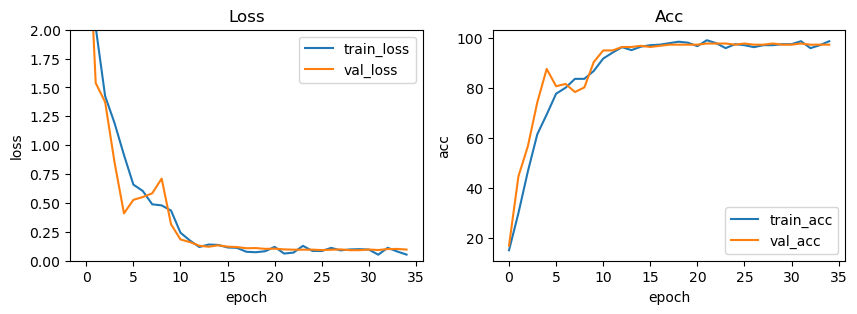

In [33]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(range(len(r_50_history['train_loss'])),r_50_history['train_loss'], label='train_loss')
plt.plot(range(len(r_50_history['train_loss'])),r_50_history['val_loss'], label='val_loss')
plt.ylim(0,2)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(r_50_history['train_loss'])), r_50_history['train_acc'], label='train_acc')
plt.plot(range(len(r_50_history['train_loss'])), r_50_history['val_acc'], label='val_acc')
plt.title('Acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()

plt.show()

DenseNet

In [22]:
densenet = DenseNet.load_model(growth_rate=32, block_config=(6, 12, 24, 16), num_init_features =64 ,num_classes = 10)
#print(densenet)
#torchsummary.summary(densnet,(3,224,224),device='cpu')
print('# DenseNet parameters:', sum(param.numel() for param in densenet.parameters()))

# DenseNet parameters: 6964106


In [39]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=densenet.parameters(), lr=0.005,momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
# dense_history=train(densenet,optimizer,criterion,train_loader, scheduler, device, 'densenet')

100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


1 Train loss : 1.92691


100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


Val loss : 1.4464, Acc : 131/217 :60.4
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


2 Train loss : 0.99361


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.6637, Acc : 188/217 :86.6
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


3 Train loss : 0.57769


100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


Val loss : 0.4859, Acc : 185/217 :85.3
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


4 Train loss : 0.40840


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.4058, Acc : 199/217 :91.7
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


5 Train loss : 0.31824


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.2812, Acc : 200/217 :92.2
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


6 Train loss : 0.19110


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.2690, Acc : 202/217 :93.1
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


7 Train loss : 0.15217


100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


Val loss : 0.2270, Acc : 207/217 :95.4
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


8 Train loss : 0.15777


100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


Val loss : 0.1773, Acc : 208/217 :95.9
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.46it/s]


9 Train loss : 0.10424


100%|██████████| 14/14 [00:03<00:00,  3.54it/s]


Val loss : 0.1825, Acc : 206/217 :94.9


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


10 Train loss : 0.07983


100%|██████████| 14/14 [00:04<00:00,  3.48it/s]


Val loss : 0.1863, Acc : 209/217 :96.3


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


11 Train loss : 0.06876


100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


Val loss : 0.1979, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


12 Train loss : 0.03879


100%|██████████| 14/14 [00:03<00:00,  3.59it/s]


Val loss : 0.1676, Acc : 208/217 :95.9
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


13 Train loss : 0.04486


100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


Val loss : 0.1651, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


14 Train loss : 0.04444


100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


Val loss : 0.1607, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


15 Train loss : 0.04947


100%|██████████| 14/14 [00:03<00:00,  3.53it/s]


Val loss : 0.1542, Acc : 210/217 :96.8
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


16 Train loss : 0.04463


100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


Val loss : 0.1524, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.46it/s]


17 Train loss : 0.03965


100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


Val loss : 0.1478, Acc : 210/217 :96.8
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


18 Train loss : 0.04403


100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


Val loss : 0.1468, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


19 Train loss : 0.03877


100%|██████████| 14/14 [00:03<00:00,  3.53it/s]


Val loss : 0.1460, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


20 Train loss : 0.04016


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.1429, Acc : 209/217 :96.3
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


21 Train loss : 0.03569


100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


Val loss : 0.1398, Acc : 210/217 :96.8
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


22 Train loss : 0.02876


100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


Val loss : 0.1434, Acc : 210/217 :96.8


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


23 Train loss : 0.02685


100%|██████████| 14/14 [00:03<00:00,  3.55it/s]


Val loss : 0.1296, Acc : 210/217 :96.8
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


24 Train loss : 0.03248


100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


Val loss : 0.1352, Acc : 210/217 :96.8


100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


25 Train loss : 0.03250


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.1351, Acc : 210/217 :96.8


100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


26 Train loss : 0.03394


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.1309, Acc : 210/217 :96.8


100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


27 Train loss : 0.03132


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.1443, Acc : 209/217 :96.3


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


28 Train loss : 0.03756


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Val loss : 0.1368, Acc : 210/217 :96.8


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


29 Train loss : 0.03560


100%|██████████| 14/14 [00:03<00:00,  3.62it/s]

Val loss : 0.1387, Acc : 210/217 :96.8
Early stopping


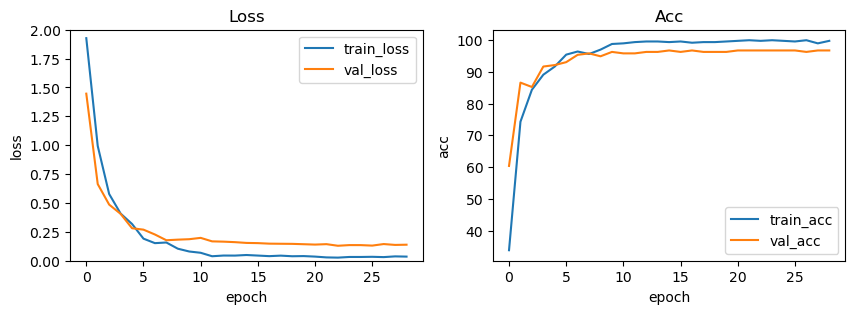

In [40]:
# plt.figure(figsize=(10,3))
# plt.subplot(1,2,1)
# plt.plot(range(len(dense_history['train_loss'])),dense_history['train_loss'], label='train_loss')
# plt.plot(range(len(dense_history['train_loss'])),dense_history['val_loss'], label='val_loss')
# plt.ylim(0,2)
# plt.title('Loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(range(len(dense_history['train_loss'])), dense_history['train_acc'], label='train_acc')
# plt.plot(range(len(dense_history['train_loss'])), dense_history['val_acc'], label='val_acc')
# plt.title('Acc')
# plt.ylabel('acc')
# plt.xlabel('epoch')
# plt.legend()

# plt.show()

EfficientNet

In [23]:
from torchvision import models
from torchvision.models import efficientnet_b0
import torch.nn as nn
from torch.nn import functional as F

effi_net = efficientnet_b0()

print(effi_net.classifier)

in_eff = 1280

e_classifier=nn.Sequential(
    nn.Linear(in_eff,1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000,10),

)
# 기본 모델은 fc 마지막이 1000개의 분류 , 맞춰주어야한다
effi_net.classifier = e_classifier
print('# EfficientNet parameters:', sum(param.numel() for param in effi_net.parameters()))


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
# EfficientNet parameters: 5298558


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effi_net.parameters(), lr=0.0005)
#scheduler=None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.2)
e_history =train(effi_net, optimizer,criterion, train_loader, scheduler, device, 'efficientb0')


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


1 Train loss : 2.10937


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


Val loss : 2.4244, Acc : 21/217 :9.7
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


2 Train loss : 1.57010


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


Val loss : 3.4172, Acc : 23/217 :10.6


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


3 Train loss : 1.41134


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Val loss : 0.9698, Acc : 140/217 :64.5
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


4 Train loss : 1.06568


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


Val loss : 1.0484, Acc : 142/217 :65.4


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


5 Train loss : 0.90387


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Val loss : 0.7011, Acc : 165/217 :76.0
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


6 Train loss : 0.71768


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Val loss : 0.9217, Acc : 157/217 :72.4


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


7 Train loss : 0.69113


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Val loss : 0.5531, Acc : 187/217 :86.2
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


8 Train loss : 0.72397


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.6296, Acc : 169/217 :77.9


100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


9 Train loss : 0.59123


100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


Val loss : 0.3947, Acc : 186/217 :85.7
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


10 Train loss : 0.53673


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.3727, Acc : 187/217 :86.2
Model Saved


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


11 Train loss : 0.42640


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


Val loss : 0.3348, Acc : 195/217 :89.9
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


12 Train loss : 0.25817


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Val loss : 0.2485, Acc : 199/217 :91.7
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


13 Train loss : 0.22748


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


Val loss : 0.2405, Acc : 197/217 :90.8
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


14 Train loss : 0.24660


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


Val loss : 0.2582, Acc : 198/217 :91.2


100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


15 Train loss : 0.19854


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


Val loss : 0.2587, Acc : 200/217 :92.2


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


16 Train loss : 0.21388


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


Val loss : 0.2282, Acc : 204/217 :94.0
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


17 Train loss : 0.21309


100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


Val loss : 0.2379, Acc : 201/217 :92.6


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


18 Train loss : 0.16080


100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


Val loss : 0.2333, Acc : 202/217 :93.1


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


19 Train loss : 0.14018


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.2170, Acc : 204/217 :94.0
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


20 Train loss : 0.13347


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


Val loss : 0.2046, Acc : 207/217 :95.4
Model Saved


100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


21 Train loss : 0.12057


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.2081, Acc : 204/217 :94.0


100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


22 Train loss : 0.13587


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


Val loss : 0.2049, Acc : 206/217 :94.9


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


23 Train loss : 0.12924


100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


Val loss : 0.1984, Acc : 205/217 :94.5
Model Saved


100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


24 Train loss : 0.10446


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.2039, Acc : 205/217 :94.5


100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


25 Train loss : 0.11704


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.2033, Acc : 205/217 :94.5


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


26 Train loss : 0.10094


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


Val loss : 0.2054, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


27 Train loss : 0.10780


100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


Val loss : 0.2111, Acc : 208/217 :95.9


100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


28 Train loss : 0.08503


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Val loss : 0.2062, Acc : 207/217 :95.4


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


29 Train loss : 0.08314


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

Val loss : 0.2050, Acc : 207/217 :95.4
Early stopping


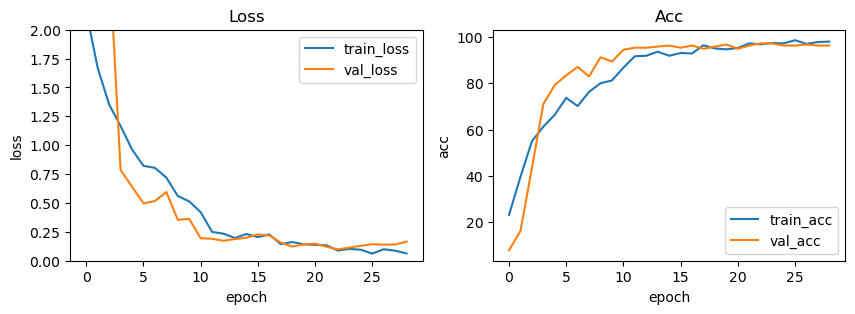

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(range(len(e_history['train_loss'])),e_history['train_loss'], label='train_loss')
plt.plot(range(len(e_history['train_loss'])),e_history['val_loss'], label='val_loss')
plt.ylim(0,2)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(e_history['train_loss'])), e_history['train_acc'], label='train_acc')
plt.plot(range(len(e_history['train_loss'])), e_history['val_acc'], label='val_acc')
plt.title('Acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()

plt.show()

예측하기

In [25]:
def inference(model,test_loader, device):
    model.to(device)
    model.eval()
    history = {}
    correct = 0
    total = 0
    classes = (
        '63 Building', 'Namsan Tower', 'Gyeongbokgung Palace', 
        'Gwangjang Market', 'Hyundai Department Store', 'Ttukseom Hangang Park', 
        'Lotte World Tower', 'Bongeunsa Temple', 'Bukchon Hanok Village', 'Seoul Forest')
    class_correct = {classname : 0 for classname in classes}
    class_total = {classname : 0 for classname in classes}

    with torch.no_grad():
        for img, labels in tqdm(iter(test_loader)):
            img, labels = img.to(device), labels.to(device)

            outputs = model(img)

            # 가장 높은 것을 예측
            _, predicted = torch.max(outputs,1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for label, predict in zip(labels,predicted):
                if label == predict:
                    class_correct[classes[label]] +=1
                class_total[classes[label]] +=1
                
    val_acc = round(100* correct / total,1)
    for i in class_correct.keys():
        class_correct[i] = round(100*class_correct[i]/class_total[i],1)
    history['val_acc']=val_acc
    history['class_correct']=class_correct
    history['class_total']=class_total
    return history

In [26]:
import seaborn as sns

def make_acc_bar(history):
    colors = sns.color_palette('hls',len(history['class_correct']))
    fig = plt.figure(figsize=(6,5))
    plt.bar(history['class_correct'].keys(),history['class_correct'].values(), color=colors)
    plt.xticks(range(len(history['class_correct'])), rotation=90)
    fig.suptitle(f"Total Acc : {history['val_acc']:.2f}%", fontsize=10)
    return fig

test dataset load

In [27]:
test_dataset = CustomDataset(val_img_path,val_label,train_mode=True,transforms=test_transform)
test_loader= DataLoader(test_dataset,batch_size =CFG['BATCH_SIZE'],shuffle=False,num_workers=0)


ResNet plot

100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


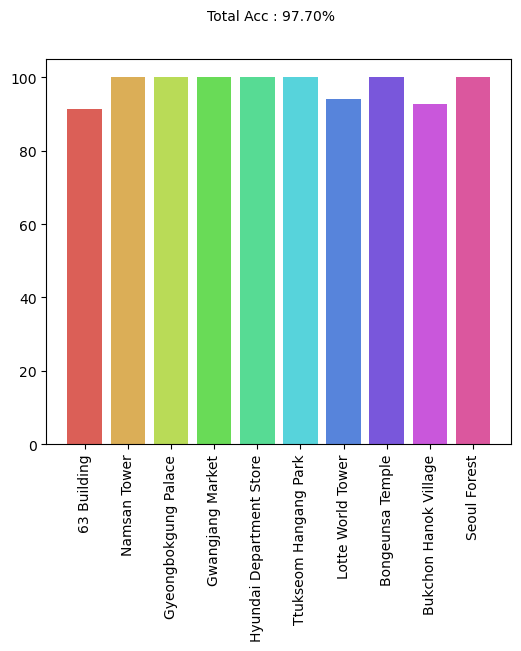

In [28]:
checkpoint = torch.load('checkpoint/best_resnet50_977.pth')
resnet50.load_state_dict(checkpoint['model_state_dict'], strict=False)

history = inference(resnet50,test_loader,device)
fig = make_acc_bar(history)


DenseNet plot

100%|██████████| 14/14 [00:04<00:00,  3.46it/s]


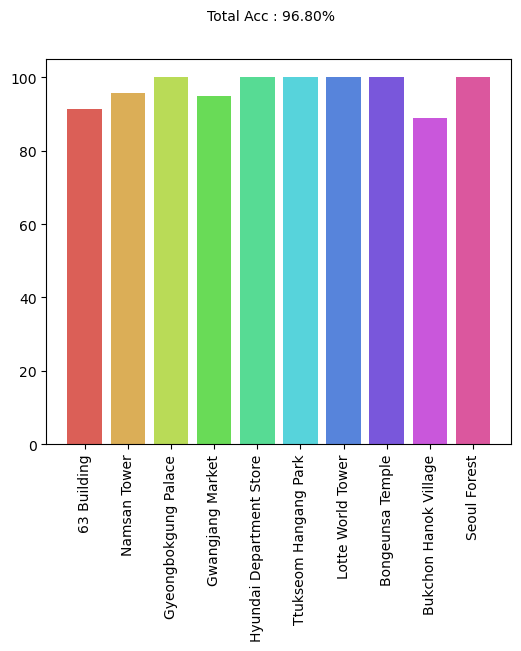

In [41]:
checkpoint = torch.load('checkpoint/best_densenet_968.pth')
densenet.load_state_dict(checkpoint['model_state_dict'], strict=False)

history = inference(densenet,val_loader,device)
fig = make_acc_bar(history)

100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


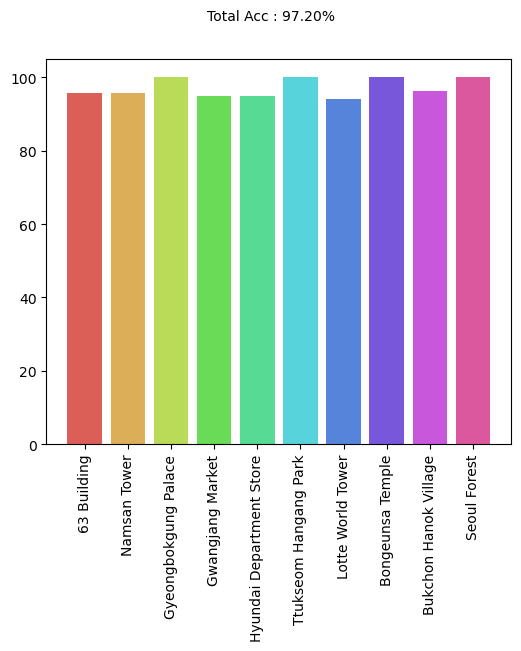

In [34]:
checkpoint = torch.load('checkpoint/best_efficientb0_972.pth')
effi_net.load_state_dict(checkpoint['model_state_dict'], strict=False)

history = inference(effi_net,val_loader,device)
fig = make_acc_bar(history)


Ensemble

In [29]:
class Ensemble(nn.Module):
    def __init__(self,model1,model2,model3):
        super(Ensemble,self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

    def forward(self,x):
        a = self.model1(x)
        b = self.model2(x)
        c = self.model3(x)
        x = a+b+c
        x = nn.Softmax(dim=1)(x)
        return x

In [31]:
print(os.getcwd())
# resnet load
checkpoint = torch.load('checkpoint/best_resnet50_977.pth')
resnet50.load_state_dict(checkpoint['model_state_dict'], strict=False)

# densenet load
checkpoint = torch.load('checkpoint/best_densenet_968.pth')
densenet.load_state_dict(checkpoint['model_state_dict'], strict=False)


# efficientnetb0 load
checkpoint = torch.load('checkpoint/best_efficientb0_972.pth')
effi_net.load_state_dict(checkpoint['model_state_dict'], strict=False)

/home/seunmul/KNU_AICOSS_bitso


<All keys matched successfully>

100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


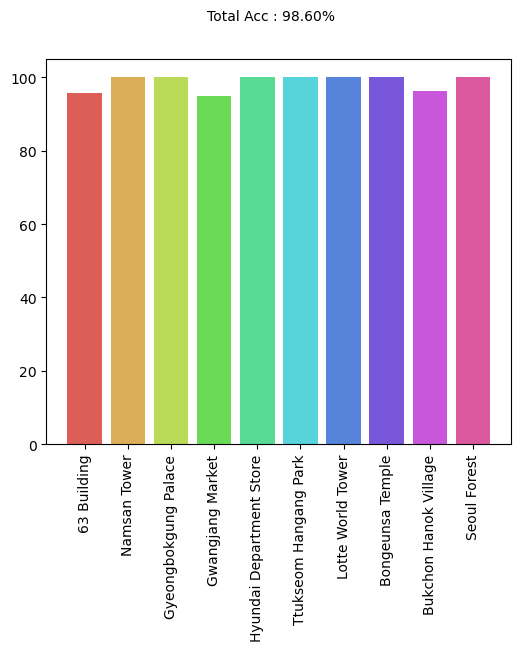

In [32]:
ensemble = Ensemble(resnet50, densenet, effi_net)
history = inference(ensemble,val_loader,device)
fig = make_acc_bar(history)